In [74]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import statsmodels.formula.api as smf
from sklearn import linear_model

In [5]:
iter_csv = pd.read_table('./data/mapAffil_2016_nonull.tsv', sep='\t', encoding='latin-1',
                         dtype={'PMID': object, 
                                'au_order': np.int64, 
                                'year': np.int64,
                                'type': object, 
                                'city': object, 
                                'state':object, 
                                'country': object,
                                'lat': np.float64, 
                                'lon': np.float64, 
                                'fips': object},
                         iterator=True, chunksize=10**6)

mapAffil = pd.concat([chunk[pd.notnull(chunk['fips'])] for chunk in iter_csv])
mapAffil = mapAffil.drop(['Unnamed: 0'], 1)

### mortality data
mort = pd.read_table('./data/mortality.tsv',sep='\t', encoding='latin-1', na_values='Missing',
                    dtype={'fips': object})



In [6]:
#reshape mortality data
mort_rate = mort.loc[(mort.metric == 'rate')]
mort_expanded = mort_rate.drop(labels='metric', axis=1)
mort_expanded.index.name = 'original'
mort_expanded.set_index(['fips', 'cause'], append=True, inplace=True)
mort_expanded = mort_expanded.reorder_levels(['original','fips', 'cause'])
# .stack() removes NaN value rows
mort_expanded = mort_expanded.stack().to_frame().reset_index()
mort_expanded = mort_expanded.rename(columns={"level_3":"year", 0:"rate"})
#create year columns
mort_expanded.year = mort_expanded.year.str[1:]
mort_expanded['year'] = pd.to_numeric(mort_expanded['year'])
mort_expanded = mort_expanded.drop(labels=['original'], axis=1)

In [16]:
#Create mapAffil publication count columns
count_PMID_by_year_fips = mapAffil.groupby(['fips', 'year'])['PMID'].nunique()
count_PMID_by_year_fips = pd.DataFrame(count_PMID_by_year_fips)
count_PMID_by_year_fips.columns = ['PMID_count']

In [22]:
types_all = pd.merge(mapAffil.loc[:,['fips','year', 'type']], count_PMID_by_year_fips, right_index=True, left_on=['fips', 'year'], how='outer')
types_count = types_all.groupby(['fips', 'year', 'type']).agg({'type': len}).rename(columns={'type': 'type_count'})
types_count = types_count.reset_index()
types_count = pd.pivot_table(types_count, values='type_count', index=['fips', 'year'], columns=['type'])


In [23]:
#Don't run twice
#types_count = types_count.reset_index()
types_count.head()

type        COM  EDU  EDU-HOS  GOV  HOS  MIL  ORG  UNK
fips  year                                            
01001 1992  NaN  NaN      NaN  NaN  2.0  NaN  NaN  NaN
      2016  NaN  NaN      NaN  NaN  NaN  NaN  NaN  1.0
01003 1989  NaN  NaN      NaN  NaN  1.0  NaN  NaN  NaN
      1990  NaN  NaN      NaN  NaN  NaN  NaN  NaN  1.0
      1993  1.0  NaN      NaN  NaN  NaN  NaN  NaN  NaN

In [21]:
count_PMID_by_year_fips.head()

PMID_count
fips  year            
01001 1992           2
      2016           1
01003 1989           1
      1990           1
      1993           1

In [36]:
pubs_merged = pd.merge(types_count, count_PMID_by_year_fips, right_index=True, left_index=True, how='outer')
pubs_merged = pubs_merged.fillna(0)
pubs_merged = pubs_merged.reset_index()
pubs_merged.head(10)

type,fips,year,COM,EDU,EDU-HOS,GOV,HOS,MIL,ORG,UNK,PMID_count
0,01001,1992,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2
1,01001,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,01003,1989,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,01003,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,01003,1993,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,01003,1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
6,01003,1995,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
7,01003,1996,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2
8,01003,1997,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
9,01003,2000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2


In [51]:
mort_expanded.head(10)

,fips,cause,year,rate
0,01001,all,1999,1064.73351
1,01001,all,2000,1021.78792
2,01001,all,2001,1008.79702
3,01001,all,2002,1037.62083
4,01001,all,2003,1038.44489
5,01001,all,2004,934.52341
6,01001,all,2005,1123.39499
7,01001,all,2006,1073.07450
8,01001,all,2007,906.71136
9,01001,all,2008,975.42381


In [45]:
all_values = pd.merge(pubs_merged, mort_expanded, right_on=['fips', 'year'], left_on=['fips', 'year'], how='left')
all_values

type,fips,year,COM,EDU,EDU-HOS,GOV,HOS,MIL,ORG,UNK,PMID_count,cause,rate
0,01001,1992,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2,NaN,NaN
1,01001,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,NaN,NaN
2,01003,1989,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,NaN,NaN
3,01003,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,NaN,NaN
4,01003,1993,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN
5,01003,1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,NaN,NaN
6,01003,1995,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,NaN,NaN
7,01003,1996,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2,NaN,NaN
8,01003,1997,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,NaN,NaN
9,01003,2000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2,all,844.35639


In [46]:
mort_pubs = pd.read_table('./data/mort_pubs.tsv', sep='\t', encoding='latin-1',
                         dtype={'fips': object})

# drop first column
mort_pubs = mort_pubs.drop(['Unnamed: 0'], 1)

In [47]:
mort_pubs.head()

,fips,cause,year,rate,delta_pub,delta_rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,...,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
0,01001,all,1999,1064.73351,-0.007337,-10.863475,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,01001,all,2000,1021.78792,-0.007337,-10.863475,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,01001,all,2001,1008.79702,-0.007337,-10.863475,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,01001,all,2002,1037.62083,-0.007337,-10.863475,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,01001,all,2003,1038.44489,-0.007337,-10.863475,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [48]:
mort_pubs.loc[:,['fips', 'year', 'cause', 'rate', 'delta_rate']].drop_duplicates()

,fips,year,cause,rate,delta_rate
0,01001,1999,all,1064.73351,-10.863475
1,01001,2000,all,1021.78792,-10.863475
2,01001,2001,all,1008.79702,-10.863475
3,01001,2002,all,1037.62083,-10.863475
4,01001,2003,all,1038.44489,-10.863475
5,01001,2004,all,934.52341,-10.863475
6,01001,2005,all,1123.39499,-10.863475
7,01001,2006,all,1073.07450,-10.863475
8,01001,2007,all,906.71136,-10.863475
9,01001,2008,all,975.42381,-10.863475


## Plot death rates

21085 all


/Users/nataliedeclerck/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


,fips,cause,year,rate
46443,21085,all,1999,1014.77520
46444,21085,all,2000,1114.44513
46445,21085,all,2001,1269.78678
46446,21085,all,2002,1052.83519
46447,21085,all,2003,1092.20478


21085 circulatory


,fips,cause,year,rate
46459,21085,circulatory,1999,428.24797
46460,21085,circulatory,2000,454.83005
46461,21085,circulatory,2001,447.15363
46462,21085,circulatory,2002,420.82598
46463,21085,circulatory,2003,398.23043


21085 mental


,fips,cause,year,rate


21085 neoplasms


,fips,cause,year,rate
46475,21085,neoplasms,1999,231.7
46476,21085,neoplasms,2000,233.0
46477,21085,neoplasms,2001,236.0
46478,21085,neoplasms,2002,214.5
46479,21085,neoplasms,2003,178.8


21085 nervous


,fips,cause,year,rate
46491,21085,nervous,2010,78.79410
46492,21085,nervous,2014,81.67709


21085 respiratory


,fips,cause,year,rate
46493,21085,respiratory,1999,142.02298
46494,21085,respiratory,2000,158.12720
46495,21085,respiratory,2001,191.60340
46496,21085,respiratory,2002,126.66065
46497,21085,respiratory,2003,177.75184


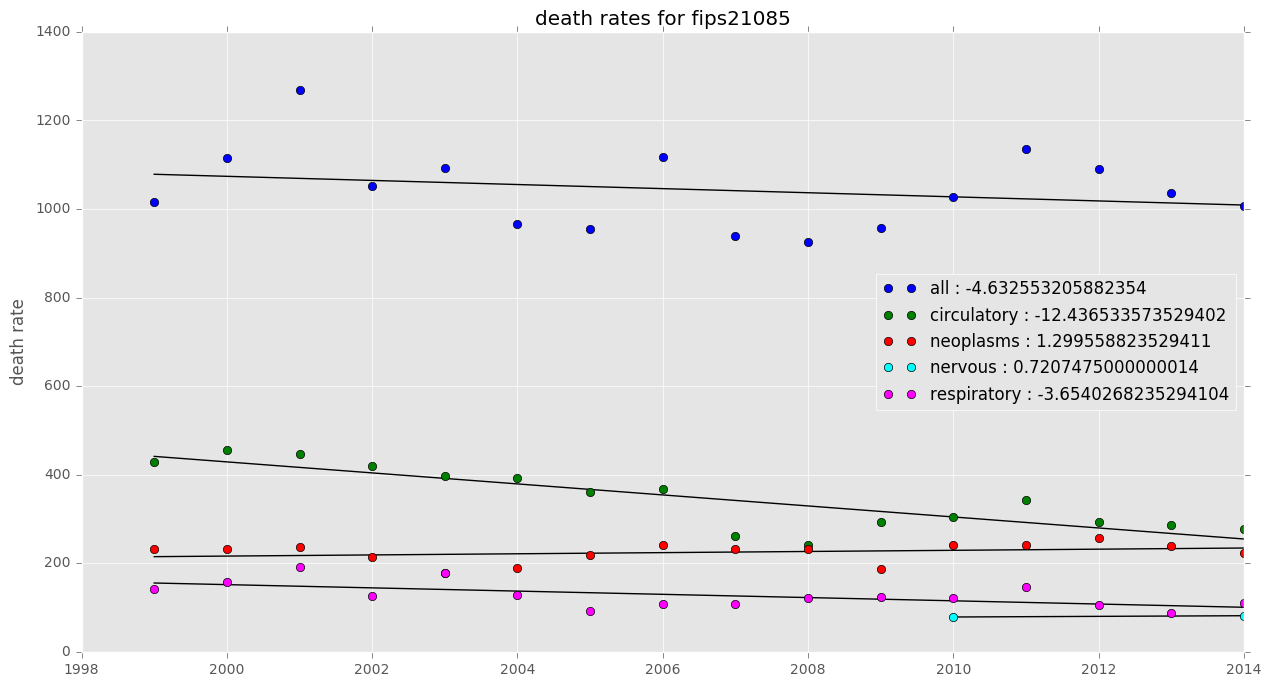

In [103]:
def plot_year_rate(fips):
    f, ax1 = plt.subplots(1, figsize=(15,8))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    ax1.set_color_cycle(colors)
    causes = ['all','circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    for cause in causes:
        df = mort_pubs.loc[(mort_pubs.cause == cause) & (mort_pubs.fips == fips), ['fips', 'cause', 'year', 'rate']]
        print(fips,cause)
        display(df.head())
        idx = causes.index(cause)
        #print("before if",colors[idx])
        if len(df)>0:
            #print("if clause",colors[idx])
            regr = linear_model.LinearRegression()
            regr.fit(df.year.to_frame(), df.rate.to_frame())
            #print(regr.coef_)
            ax1.plot(df.year.to_frame(), regr.predict(df.year.to_frame()), color='black', linewidth=1)

            points, = ax1.plot(df['year'], df['rate'], 'o', label=cause+' : {}'.format(regr.coef_[0][0]))

    ax1.set_title('death rates for fips'+fips)
    ax1.set_ylabel('death rate')
    ax1.legend(loc='best')
    plt.show()

plot_year_rate('21085')

In [97]:
# dont run twice
count_PMID_by_year_fips = count_PMID_by_year_fips.reset_index()
count_PMID_by_year_fips.head()

,fips,year,PMID_count
0,01001,1992,2
1,01001,2016,1
2,01003,1989,1
3,01003,1990,1
4,01003,1993,1


,fips,year,PMID_count,log_PMID,square_PMID
18700,25017,1881,1,0.301030,1
18701,25017,1885,2,0.477121,4
18702,25017,1887,2,0.477121,4
18703,25017,1889,2,0.477121,4
18704,25017,1890,2,0.477121,4


[[ 0.02732263]]


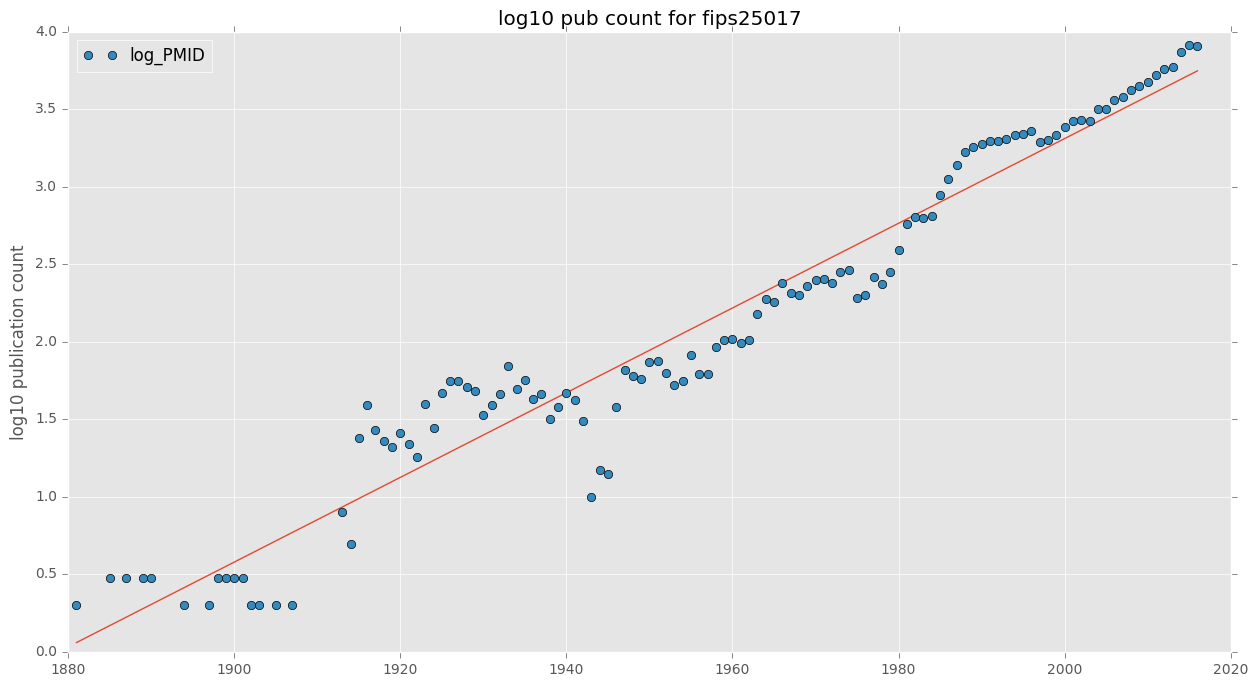

,fips,year,PMID_count,log_PMID,square_PMID
15174,21085,1989,1,0.301030,1
15175,21085,1990,2,0.477121,4
15176,21085,1991,3,0.602060,9


[[ 0.150515]]


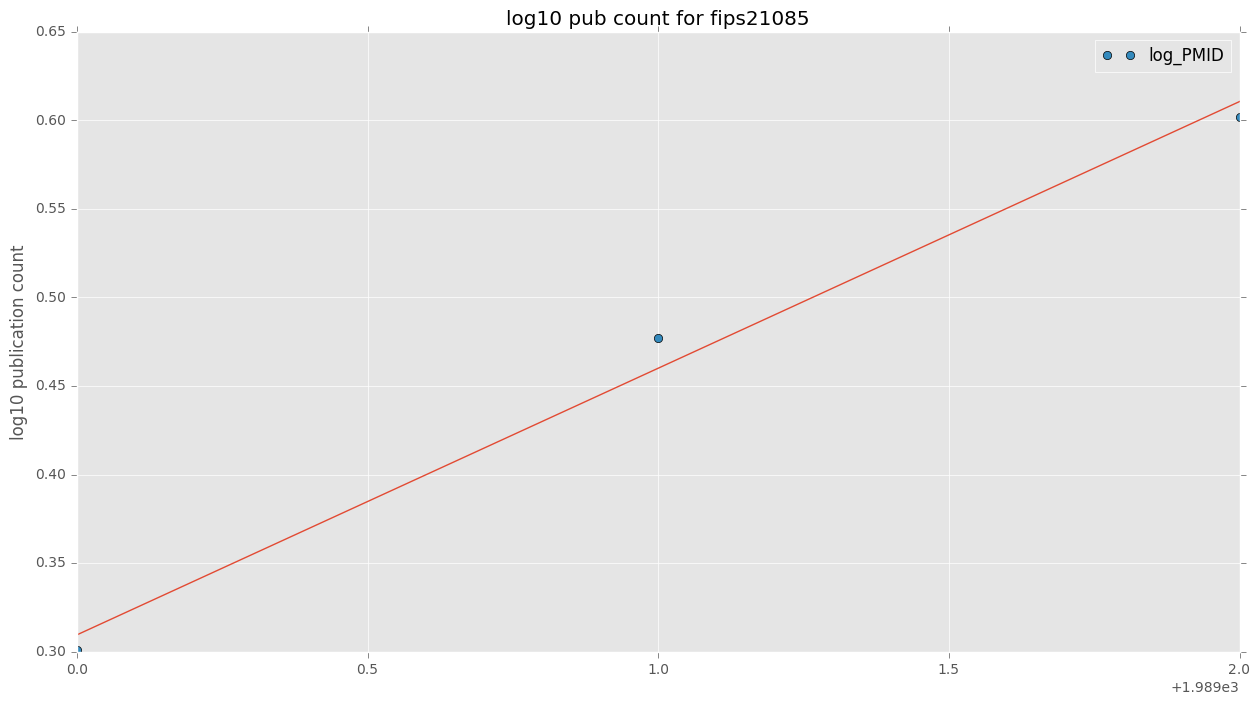

In [104]:
### change this to plot year x pubs for a fips using mort_pubs
def plot_year_pubs(fips):
    f, ax1 = plt.subplots(1, figsize=(15,8))

    df = count_PMID_by_year_fips.loc[(count_PMID_by_year_fips.fips == fips) & (count_PMID_by_year_fips.year < 2017), ['fips', 'year', 'PMID_count']]
    df = df.drop_duplicates()
    df['log_PMID'] = np.log10(df['PMID_count']+1)
    df['square_PMID'] = df['PMID_count']**2
    display(df.head())

    #yr_pubs = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause), pubs_cols]
    #numeric_only=True so FIPS code is not added to sum
    #pub_sums = yr_pubs.sum(axis=1, numeric_only=True)
    #pub_logs = np.log10(pub_sums + 1)
    #pubs_squared = pub_sums**2
    
    regr = linear_model.LinearRegression()
    regr.fit(df.year.to_frame(), df.log_PMID.to_frame())
    print(regr.coef_)
    ax1.plot(df.year.to_frame(), regr.predict(df.year.to_frame()), linewidth=1)

    ax1.plot(df['year'], df['log_PMID'], 'o')

    ax1.set_title('log10 pub count for fips'+fips)
    ax1.set_ylabel('log10 publication count')
    ax1.legend(loc='best')
    plt.show()

#no change   
#plot_year_pubs('51177')

#plot_year_pubs('01001')

# plot_year_pubs('17019') #CU
plot_year_pubs('25017') #Boston
# plot_year_pubs('17031') #Chicago
# plot_year_pubs('06087') #LA

# outliers where delta_pubs > 0.08
plot_year_pubs('21085') # Leitchfield, KY
# plot_year_pubs('26141') # Millersburg, MI
# plot_year_pubs('01071') # Princeton, AL


---
## Look up fips codes

In [67]:
fips = '48359'
mapAffil.loc[(mapAffil.fips == fips), :]

,PMID,au_order,year,type,city,state,country,lat,lon,fips
133422,12421011,1,2003,COM,"Vega, TX, USA",TX,USA,35.242,-102.428,48359
562566,16148577,1,2005,UNK,"Vega, TX, USA",TX,USA,35.242,-102.428,48359
893731,6695558,4,1984,UNK,"Vega, TX, USA",TX,USA,35.242,-102.428,48359
893732,6695558,5,1984,UNK,"Vega, TX, USA",TX,USA,35.242,-102.428,48359
893733,6695558,3,1984,UNK,"Vega, TX, USA",TX,USA,35.242,-102.428,48359
893734,6695558,6,1984,UNK,"Vega, TX, USA",TX,USA,35.242,-102.428,48359
120909,18936969,2,2009,ORG,"Vega, TX, USA",TX,USA,35.242,-102.428,48359
35451,21930910,6,2011,UNK,"Vega, TX, USA",TX,USA,35.242,-102.428,48359


In [68]:
city = 'Chicago'
mapAffil.loc[(mapAffil.city.str.contains(city)), :]

,PMID,au_order,year,type,city,state,country,lat,lon,fips
71,26151823,1,2015,EDU,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031
72,26151823,2,2015,EDU-HOS,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031
73,26151823,3,2015,EDU-HOS,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031
74,26151823,4,2015,EDU-HOS,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031
75,26151823,5,2015,EDU-HOS,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031
76,26151823,6,2015,EDU-HOS,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031
77,26151823,7,2015,EDU,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031
78,26151823,8,2015,EDU-HOS,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031
79,26151823,9,2015,EDU-HOS,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031
80,26151823,10,2015,EDU,"Chicago, IL, USA",IL,USA,41.884,-87.632,17031


#### lat and lon and city at a lower than fips level --- remove?

In [27]:
pubs_merged = pd.merge(mapAffil.loc[:,['fips','year', 'lat', 'lon']], pubs_merged, right_index=True, left_on=['fips', 'year'], how='outer')
pubs_merged.head()

,fips,year,lat,lon,COM,EDU,EDU-HOS,GOV,HOS,MIL,ORG,UNK,PMID_count
0,04019,2016,32.222,-110.97,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941
10165,04019,2016,32.222,-110.97,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941
10166,04019,2016,32.222,-110.97,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941
10167,04019,2016,32.222,-110.97,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941
10168,04019,2016,32.222,-110.97,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941


In [29]:
pubs_merged.drop_duplicates()

,fips,year,lat,lon,COM,EDU,EDU-HOS,GOV,HOS,MIL,ORG,UNK,PMID_count
0,04019,2016,32.222,-110.970,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941
515750,04019,2016,32.391,-110.966,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941
795525,04019,2016,31.906,-110.984,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941
103244,04019,2016,32.203,-110.968,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941
243398,04019,2016,32.414,-111.173,103.0,3941.0,739.0,17.0,44.0,1.0,124.0,67.0,1941
1,06037,2016,34.053,-118.245,1059.0,22266.0,4851.0,42.0,4846.0,10.0,1910.0,1129.0,12781
2234,06037,2016,34.064,-118.446,1059.0,22266.0,4851.0,42.0,4846.0,10.0,1910.0,1129.0,12781
2311,06037,2016,34.140,-117.972,1059.0,22266.0,4851.0,42.0,4846.0,10.0,1910.0,1129.0,12781
8586,06037,2016,33.985,-118.452,1059.0,22266.0,4851.0,42.0,4846.0,10.0,1910.0,1129.0,12781
11269,06037,2016,34.077,-118.376,1059.0,22266.0,4851.0,42.0,4846.0,10.0,1910.0,1129.0,12781


In [28]:
mapAffil.loc[(mapAffil.fips == '04019'),:]

,PMID,au_order,year,type,city,state,country,lat,lon,fips
0,26151952,1,2016,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
845,26151022,2,2015,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
2176,26149805,1,2015,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
2292,26149676,6,2015,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
2307,26149671,1,2015,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
3524,26148321,1,2015,EDU-HOS,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
3525,26148321,2,2015,EDU-HOS,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
3526,26148321,3,2015,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
3527,26148321,4,2015,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
4261,26147538,1,2015,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.97,04019
